In [1]:
#библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_excel('dinamic_sep.xlsx',index_col=[0],parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2016-09-01 to 2019-09-30
Data columns (total 5 columns):
min_temp       120 non-null float64
mean_temp      120 non-null float64
max_temp       120 non-null float64
deviation      120 non-null float64
fallout, mm    120 non-null float64
dtypes: float64(5)
memory usage: 5.6 KB


In [4]:
data.sort_index(inplace = True)
data.index.is_monotonic

True

In [5]:
data

,min_temp,mean_temp,max_temp,deviation,"fallout, mm"
day of month,,,,,
2016-09-01,9.1,13.7,19.3,-0.5,0.0
2016-09-02,9.9,16.3,23.0,2.3,0.0
2016-09-03,13.3,16.5,20.7,2.7,0.3
2016-09-04,11.3,14.2,17.4,0.7,2.4
2016-09-05,12.7,14.5,16.2,1.2,13.8
...,...,...,...,...,...
2019-09-26,4.3,6.9,12.4,-2.4,0.4
2019-09-27,1.4,6.4,11.2,-2.8,0.0
2019-09-28,4.3,8.8,12.3,-0.2,0.3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2016-09-01 to 2019-09-30
Data columns (total 5 columns):
min_temp       120 non-null float64
mean_temp      120 non-null float64
max_temp       120 non-null float64
deviation      120 non-null float64
fallout, mm    120 non-null float64
dtypes: float64(5)
memory usage: 5.6 KB


<div class="alert alert-block alert-info"><b>
Файл открыт и изучен. Данные цифровые: различное значение температуры на каждый день сентября. Всего 5 столбецов,120 строк.
    </b></div>

# Предобработка данных

In [7]:
data.isnull().sum()

min_temp       0
mean_temp      0
max_temp       0
deviation      0
fallout, mm    0
dtype: int64

In [8]:
data.isnull().sum().sum()

0

In [9]:
data.duplicated().sum()

0

<div class="alert alert-block alert-info"><b>
    
Пропуски отсутствуют.

Дубликаты отсутствуют.

Типы данных в столбцах верные.
    </b></div>

# Исследовательский анализ

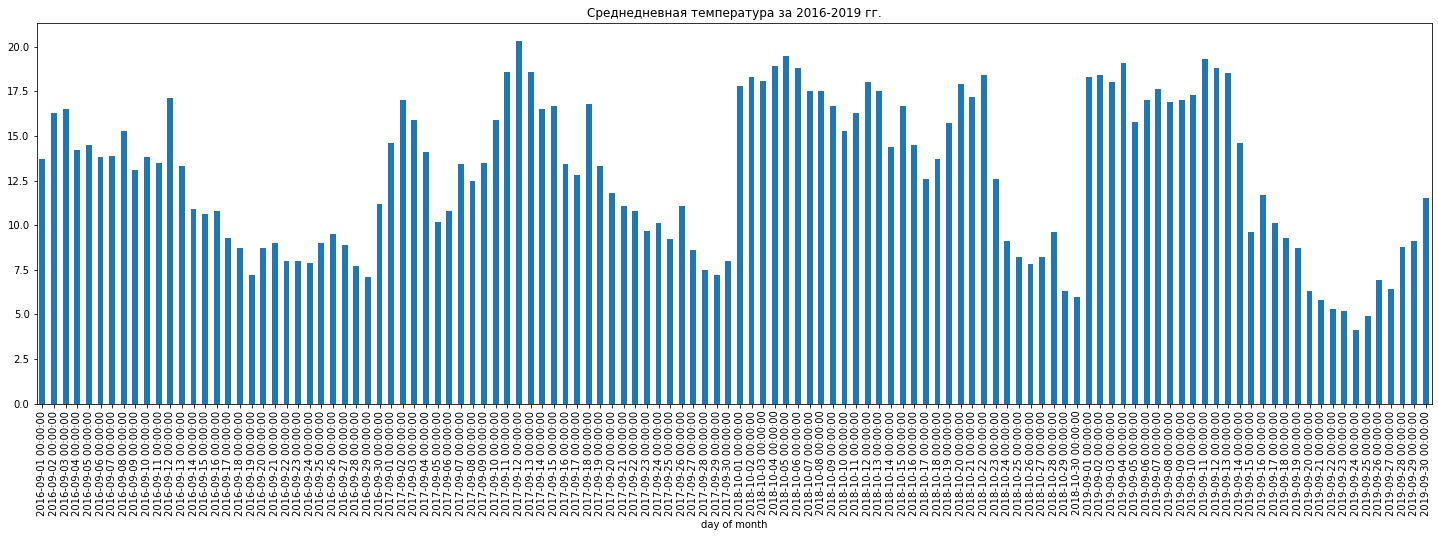

In [10]:
data['mean_temp'].plot(title = "Среднедневная температура за 2016-2019 гг.",
                  figsize = (25,7),
                  kind = 'bar')

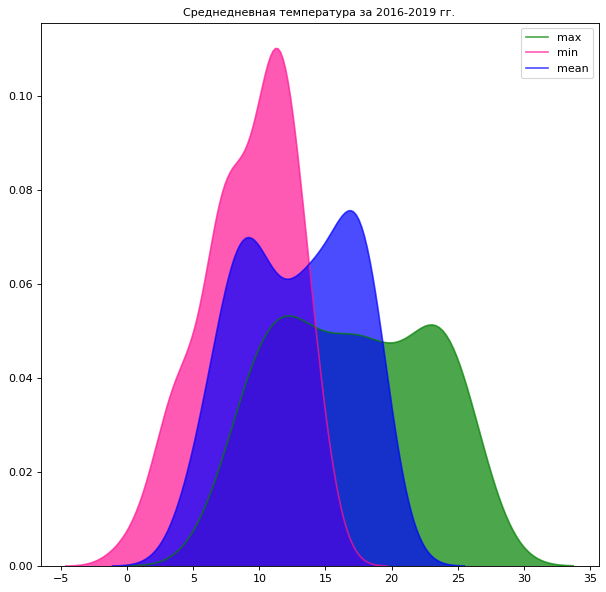

In [11]:
plt.figure(figsize=(9,9), dpi= 80)
sns.kdeplot(data['max_temp'], shade=True, color="g", label="max", alpha=.7)
sns.kdeplot(data['min_temp'], shade=True, color="deeppink", label="min", alpha=.7)
sns.kdeplot(data['mean_temp'], shade=True, color="blue", label="mean", alpha=.7)

# Decoration
plt.title('Среднедневная температура за 2016-2019 гг.', fontsize=10)
plt.legend()
plt.show()

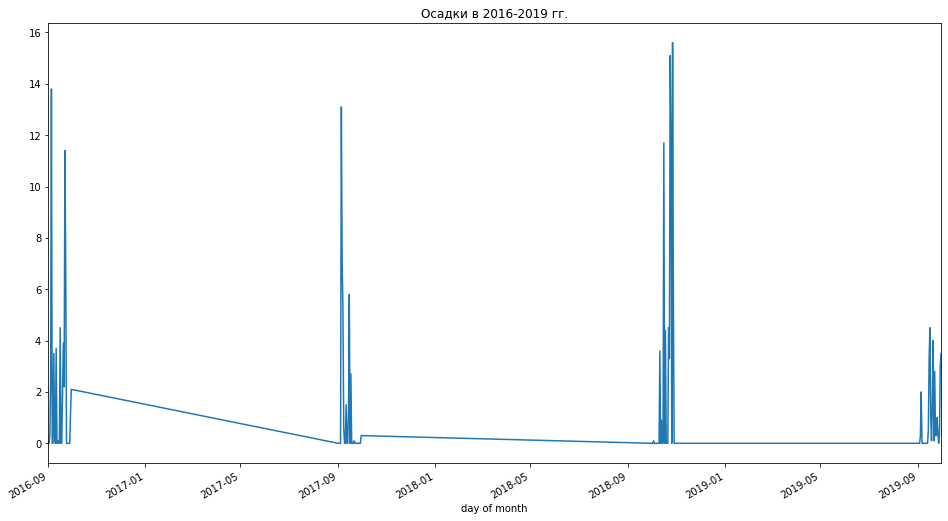

In [12]:
data['fallout, mm'].plot(title = 'Осадки в 2016-2019 гг.',figsize = (16,9))

<div class="alert alert-block alert-info"><b>
Количество осадков резко увеличивается на несколько единиц ближе к концу месяца и доходит до 15.89 мм,когда в большинстве дней месяца осадки варьируются от 0 до 2 мм.
    </b></div>

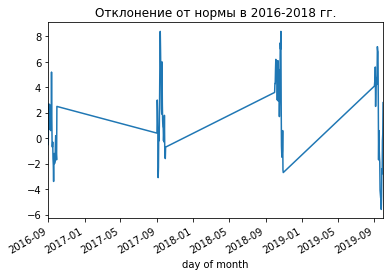

In [13]:
data['deviation'].plot(title = 'Отклонение от нормы в 2016-2018 гг.')

<div class="alert alert-block alert-info"><b>
Отклонение температуры от нормы так, как и с осадками, наблюдается во второй половине месяця, причем резкие изменения происходят,как в одну(увеличение температуры от нормы),так и в другую сторону(уменшение температуры от нормы).
    </b></div>

In [14]:
#декомпозиция
decomposition = seasonal_decompose(data['mean_temp'].values, freq=30)

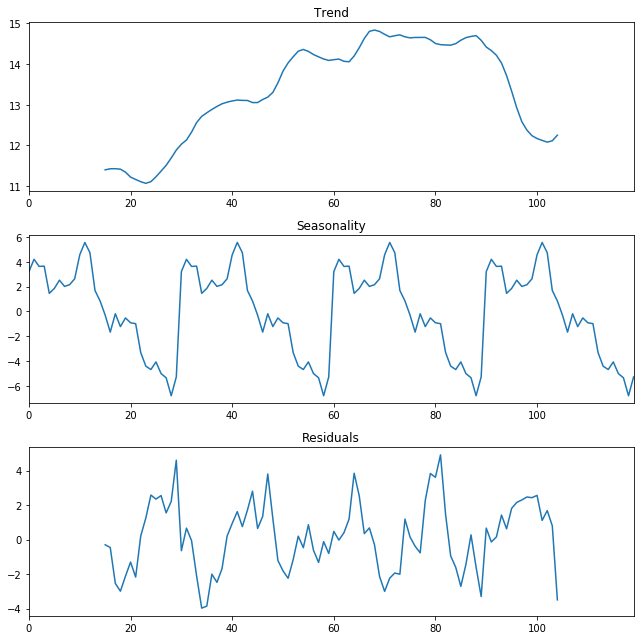

In [15]:
plt.figure(figsize=(9,9))
plt.subplot(311)
pd.Series(decomposition.trend).plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(312)
pd.Series(decomposition.seasonal).plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
pd.Series(decomposition.resid).plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

<div class="alert alert-block alert-info"><b>
    
Из графика тренда можно сказать, что с каждым годом температура имеет отклонение к повышению температуры на несколько градусов выше ранних показателей этого же дня в сентябре предыдущего года.    
    
Из графика сезонности и графика средней температуры видно, что присутствует тенденция к резкому повышению температуры(пику температуры) к 12 числу каждого месяца и  снижению температуры,начиная с 13 числа до конца каждого месяца.
    
Из результатов исследовательского анализа принято решение добавить дополнительный столбец разделения месяца(с 1 по 12 число[ожидаемый период повышения температуры] и с 13 по 30 число[ожидаемый период понижения температуры]).
    </b></div>

# Обучение модели

In [16]:
#создание признаков
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['mean_temp'].shift(lag)
    
    
make_features(data,1)

In [17]:
data = data.dropna()

In [18]:
#разделение месяца на 2 периода
data['half_month'] = 0
for i in range(len(data['day'])):
    if i >= 11 and i<=28:
        data['half_month'][i] = 1
    elif i>=41 and i<=58:
        data['half_month'][i] = 1
    elif i>=71 and i<=88:
        data['half_month'][i] = 1
    elif i>=101:
        data['half_month'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, 

In [19]:
#Целевой признак и обучающие признаки 
features = data.drop(['mean_temp','min_temp','max_temp','deviation'],axis = 1)
target = data['mean_temp']

<div class="alert alert-block alert-info"><b>
    
В качестве обучающих признаков выбраны: день,год,lag(отставание, то есть предыдущее значение целевого признака),осадки,разделение месяца на 2 периода; 
    
Температура коррелируется не только с минимальным и максимальным ее значением в течении дня, но так же и с отклонением от нормы(deviation).
    
В модели важно отследить лаги  для устранения сильного сглажвания результатов.
    </b></div>

In [20]:
#Деление на выборки
features_train,features_val,target_train,target_val = train_test_split(features,target,test_size = 0.4,shuffle = False)
features_valid,features_test,target_valid,target_test = train_test_split(features_val,target_val, test_size = 0.5,shuffle = False)

# Модель 1

In [21]:
model1 = LinearRegression()
model1.fit(features_train,target_train)
prediction1 = model1.predict(features_valid)
print('MAE:',round(mean_absolute_error(target_valid,prediction1),5))

MAE: 1.9672


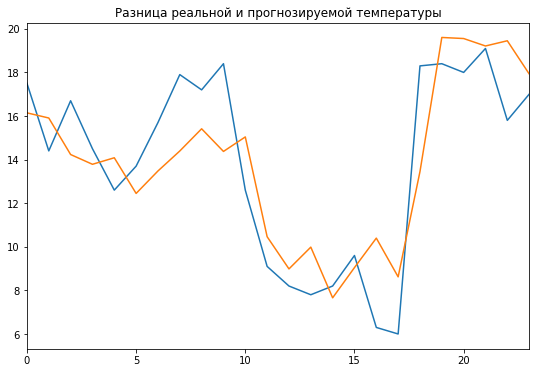

In [22]:
#график реальных и прогнозируемых результатов 
target_valid.index = np.arange(len(target_valid))
target_valid.plot(title = "Разница реальной и прогнозируемой температуры",figsize = (9,6))
pd.Series(prediction1).plot()

<div class="alert alert-block alert-info"><b>
    
Обучена модель №1.

Применена метрика MAE для определения качества модели,так как данная метрика показывает сумму средних абсалютных ошибкок прогнозов,то есть для каждой точки вычисляется разница между прогнозами и целью, а затем усредняются эти значения.

По модели № 1 метрика качества составляет 1.9672.

Построен график реальных и прогнозируемых результатов целевого признака,для понимания в каких моментах модель ошибается.
    </b></div>

# Модель 2

In [23]:
#выбор значения гиперпараметра max_depth
max_depth_array = [1, 3, 5, 6, 7, 10, 15, 20, 25]
model2 = DecisionTreeRegressor()
grid = GridSearchCV(model2, param_grid={'max_depth': max_depth_array})
grid.fit(features_train,target_train)
best_max_depth = grid.best_estimator_.max_depth
print(grid.best_score_, best_max_depth)

0.3109120676929612 5


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
model2 = DecisionTreeRegressor(random_state = 123,max_depth = 5)
model2.fit(features_train,target_train)
prediction2 = model2.predict(features_valid)
print('MAE:',round(mean_absolute_error(target_valid,prediction2),5))

MAE: 4.0348


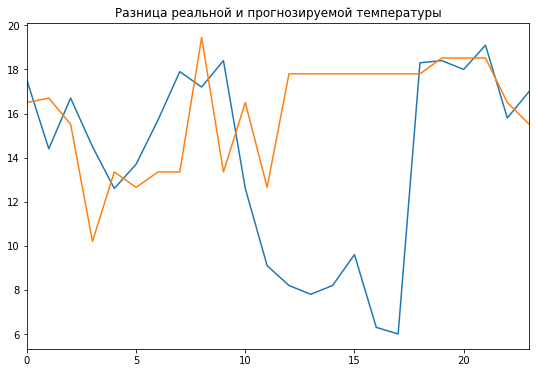

In [25]:
#график реальных и прогнозируемых результатов 
target_valid.plot(title = "Разница реальной и прогнозируемой температуры",figsize = (9,6))
pd.Series(prediction2).plot()

<div class="alert alert-block alert-info"><b>
    
Обучена модель № 2.

Выбраны оптимальные гиперпараметры.

Модель № 2: MAE: 4.0348
    
Построен график реальных и прогрозируемых моделью результатов целевого признака.
    </b><div>

# Модель 3

In [26]:
#выбор значения гиперпараметров для модели № 3
n_estimators_array = [1, 3, 5, 7, 10, 15]
max_depth_array = [1, 3, 5, 7, 10, 15,20,25]
model3 = RandomForestRegressor(random_state = 42)
grid = GridSearchCV(model3, param_grid=({'n_estimators': n_estimators_array},{'max_depth': max_depth_array}))
grid.fit(features_train,target_train)
best_max_depth = grid.best_estimator_.max_depth
best_n_estimators = grid.best_estimator_.n_estimators
print(grid.best_score_, best_n_estimators,best_max_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245:

0.4057371041600025 15 None


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [27]:
model3 = RandomForestRegressor(random_state = 42,n_estimators =15)
model3.fit(features_train,target_train)
prediction3 = model3.predict(features_valid)
print('MAE:',round(mean_absolute_error(target_valid,prediction3),5))

MAE: 1.98333


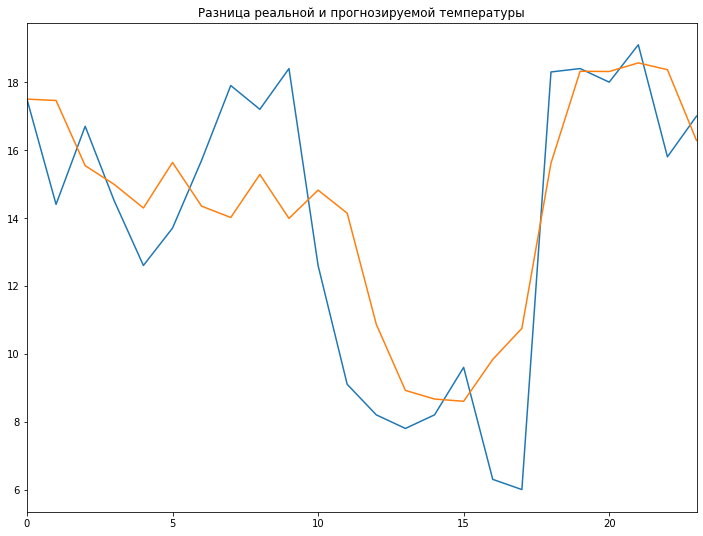

In [28]:
#график реальных и прогнозируемых результатов 
target_valid.plot(title = "Разница реальной и прогнозируемой температуры",figsize = (12,9))
pd.Series(prediction3).plot()

<div class="alert alert-block alert-info"><b>
    
Обучена модель № 3

Выбраны оптимальные гиперпараметры.

Модель № 3: MAE: 1.98333
            
Построен график реальных и прогрозируемых моделью результатов целевого признака.
    </b></div>

## Вывод по моделям

<div class="alert alert-block alert-info"><b>
Модели обучены и по ним подсчитана метрика качества MAE(средняя абсалютная ошибка).

Наилучшей моделью по качеству является модель № 1,что наглядно видно на графиках разнице реальной и прогнозируемой температуры,где предсказание целевого признака по модели № 1 находятся ближе к реальным значениям.

Метрика качества и кросс валидация каждой модели:

<font color = blue>
Модель № 1: 
MAE: 1.9672
</font>

Модель № 2:
MAE: 4.0348

Модель № 3:
MAE: 1.98333
    </b></div>

# Тест на адекватность

In [29]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train,target_train)
predictions = dummy_clf.predict(features_test)
print('MAE:',round(mean_absolute_error(target_test,predictions),5))

MAE: 4.57917


In [30]:
#модель 1
pred = model1.predict(features_test)
print('MAE:',round(mean_absolute_error(target_test,pred),5))

MAE: 2.52264


<div class="alert alert-block alert-info"><b>
Для проверки модели на адекватность был использован классификатор в качестве простой базовой линии для сравнения с реальными классификаторами. Проверка на тестовой выборке показала, что модель № 1 дает наилучший результат по используемой метрике, чем используемым для сравнения классификатор, тем самым доказывая адекватность модели.

MAE модели: 2.52264

MAE классификатора: 4.57917
    </b></div>

## Предсказание целевого признака на 2020 г.

In [31]:
september = pd.read_excel('data_september 2020.xlsx',index_col=[0], parse_dates=[0])

In [32]:
september

,mean_temp,fallout,year,day,half_month
date,,,,,
2020-09-01,19.9,0.0,2020,1,0
2020-09-02,15.1,0.0,2020,2,0
2020-09-03,17.5,0.0,2020,3,0
2020-09-04,18.4,0.0,2020,4,0
2020-09-05,18.1,0.3,2020,5,0
2020-09-06,18.4,0.3,2020,6,0
2020-09-07,18.0,0.0,2020,7,0
2020-09-08,15.6,12.0,2020,8,0
2020-09-09,12.7,5.0,2020,9,0


In [33]:
#создание признаков
def make_features(data, max_lag):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['mean_temp'].shift(lag)

    
    
make_features(september,1)

In [34]:
#удаление пропусков
september = september.dropna()

In [35]:
features_sept2020 = september.drop(['mean_temp'],axis = 1)
target_sept2020 = september['mean_temp']

In [36]:
features_sept2020 = features_sept2020[['fallout','year','day','lag_1','half_month']]

In [37]:
features_sept2020

,fallout,year,day,lag_1,half_month
date,,,,,
2020-09-02,0.0,2020,2,19.9,0
2020-09-03,0.0,2020,3,15.1,0
2020-09-04,0.0,2020,4,17.5,0
2020-09-05,0.3,2020,5,18.4,0
2020-09-06,0.3,2020,6,18.1,0
2020-09-07,0.0,2020,7,18.4,0
2020-09-08,12.0,2020,8,18.0,0
2020-09-09,5.0,2020,9,15.6,0
2020-09-10,4.3,2020,10,12.7,0


In [38]:
prediction_2020 = model1.predict(features_sept2020)

In [39]:
pd.Series(prediction_2020)

0     21.207908
1     18.668315
2     19.788582
3     20.107471
4     19.855291
5     19.947006
6     18.087686
7     17.675893
8     16.192880
9     17.057523
10    16.246197
dtype: float64

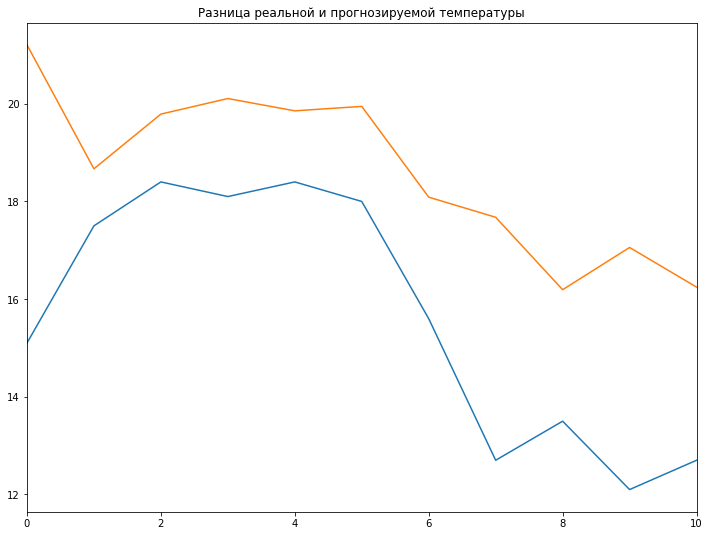

In [40]:
#график реальных и прогнозируемых результатов 
target_sept2020.index = np.arange(len(target_sept2020))
target_sept2020.plot(title = "Разница реальной и прогнозируемой температуры",figsize = (12,9))
pd.Series(prediction_2020).plot()

<div class="alert alert-block alert-info"><b>
Сделано предсказание температуры на первые 12 дней сентября 2020 года.

Построен график реальных и прогнозируемых результатов целевого признака.
</b></div>

# Общий вывод

<div class="alert alert-block alert-info"><b>
    
Источники данных:: https://meteoinfo.ru/ и http://www.pogodaiklimat.ru/
Информация о средних значениях температуры на 2016-2020 гг. на каждый день в сентябре и иные температурные показатели(минимальная температура,максимальная температура,осадки и отклонение от нормы).
    
Файл открыт и изучен. Данные цифровые: различное значение температуры на каждый день сентября. Всего 5 столбецов,120 строк.

<font color = blue> 
Предобработка данных:
</font>
    
Пропуски отсутствуют.

Дубликаты отсутствуют.

Типы данных в столбцах верные.

<font color = blue>
Исследовательский анализ:
</font>
    
Количество осадков резко увеличивается на несколько единиц ближе к концу месяца и доходит до 15.89 мм,когда в большинстве дней месяца осадки варьируются от 0 до 2 мм.
    
Отклонение температуры от нормы так, как и с осадками, наблюдается во второй половине месяця, причем резкие изменения происходят,как в одну(увеличение температуры от нормы),так и в другую сторону(уменшение температуры от нормы).
    
Из графика тренда можно сказать, что с каждым годом температура имеет отклонение к повышению температуры на несколько градусов выше ранних показателей этого же дня в сентябре предыдущего года.    
    
Из графика сезонности и графика средней температуры видно, что присутствует тенденция к резкому повышению температуры(пику температуры) к 12 числу каждого месяца и  снижению температуры,начиная с 13 числа до конца каждого месяца.
    
Из результатов исследовательского анализа принято решение добавить дополнительный столбец разделения месяца(с 1 по 12 число[ожидаемый период повышения температуры] и с 13 по 30 число[ожидаемый период понижения температуры]).

<font color = blue>
Обучение моделей:
</font>
    
В качестве обучающих признаков выбраны: день,год,lag(отставание, то есть предыдущее значение целевого признака),осадки,разделение месяца на 2 периода;

Температура коррелируется не только с минимальным и максимальным ее значением в течении дня, но так же и с отклонением от нормы(deviation).

В модели важно отследить лаги для устранения сильного сглажвания результатов.
    
Модели обучены и по ним подсчитана метрика качества MAE(средняя абсалютная ошибка).

Наилучшей моделью по качеству является модель № 1,что наглядно видно на графиках разнице реальной и прогнозируемой температуры,где предсказание целевого признака по модели № 1 находятся ближе к реальным значениям.

Метрика качества и кросс валидация каждой модели:

Модель № 1: 
MAE: 1.9672

Модель № 2:
MAE: 4.0348

Модель № 3:
MAE: 1.98333

<font color = blue>
Тест на адекватность модели:
</font>
    
Для проверки модели на адекватность был использован классификатор в качестве простой базовой линии для сравнения с реальными классификаторами. Проверка на тестовой выборке показала, что модель № 1 дает наилучший результат по используемой метрике, чем используемым для сравнения классификатор, тем самым доказывая адекватность модели.

MAE модели: 2.52264

MAE классификатора: 4.57917

    
<font color = blue>
Итог: 
</font>
    
Сделано предсказание температуры на первые 12 дней сентября 2020 года.

Построен график реальных и прогнозируемых результатов целевого признака.

</b></div>